In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'SP600_AdjClose_Volume_Return.csv'
data = pd.read_csv(file_path)

# Data Cleaning
data_cleaned = data.dropna(subset=['Return']).drop_duplicates()
data_cleaned['Return'] = pd.to_numeric(data_cleaned['Return'], errors='coerce')
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])
data_cleaned = data_cleaned.dropna(subset=['Return'])

# Adding New Features (rolling return, rolling volatility, RSI, and volume)
data_cleaned['rolling_return'] = data_cleaned.groupby('Ticker')['Return'].rolling(window=10).mean().reset_index(0, drop=True)
data_cleaned['rolling_volatility'] = data_cleaned.groupby('Ticker')['Return'].rolling(window=10).std().reset_index(0, drop=True)

# RSI calculation
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Apply RSI calculation and reset index
data_cleaned['rsi'] = data_cleaned.groupby('Ticker')['Return'].apply(calculate_rsi).reset_index(level=0, drop=True)

# Standardization for the four features
scaler = StandardScaler()
data_cleaned[['rolling_return_scaled', 'rolling_volatility_scaled', 'rsi_scaled', 'volume_scaled']] = scaler.fit_transform(
    data_cleaned[['rolling_return', 'rolling_volatility', 'rsi', 'Volume']])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_cleaned[['rolling_return_scaled', 'rolling_volatility_scaled', 'rsi_scaled', 'volume_scaled']] = imputer.fit_transform(
    data_cleaned[['rolling_return_scaled', 'rolling_volatility_scaled', 'rsi_scaled', 'volume_scaled']])

# Split train and test set (80% train, 20% test)
train_data, test_data = train_test_split(data_cleaned, test_size=0.2, random_state=42)

# Function to train Isolation Forest and compare results
def train_and_evaluate_isolation_forest(features, train_data, test_data):
    # Isolation Forest model
    iso_forest = IsolationForest(random_state=42)

    # Fit the model on the training set
    iso_forest.fit(train_data[features])

    # Predict anomalies on the training and test set
    train_data['anomaly'] = iso_forest.predict(train_data[features])
    test_data['anomaly'] = iso_forest.predict(test_data[features])

    # Count the anomalies
    train_anomaly_count = train_data['anomaly'].value_counts()
    test_anomaly_count = test_data['anomaly'].value_counts()

    # Plot results without the 'label' argument
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train_data, x='Date', y='Return', hue='anomaly', palette={1: 'blue', -1: 'red'})
    sns.scatterplot(data=test_data, x='Date', y='Return', hue='anomaly', palette={1: 'green', -1: 'orange'})
    plt.title(f'Anomaly Detection using {features}')
    plt.xlabel('Date')
    plt.ylabel('Stock Return')
    plt.xticks(rotation=45)
    plt.legend(title='Anomaly')
    plt.show()

    # Return train and test anomaly counts for comparison
    return train_anomaly_count, test_anomaly_count

features_list= [
    ['rolling_return_scaled', 'rolling_volatility_scaled', 'rsi_scaled', 'volume_scaled']
]

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to train Isolation Forest and evaluate precision, recall, and F1 score
def evaluate_isolation_forest_performance(features, train_data, test_data):
    # Isolation Forest model
    iso_forest = IsolationForest(random_state=42)
    
    # Fit the model on the training set
    iso_forest.fit(train_data[features])

    # Predict anomalies on the test set
    test_data['anomaly'] = iso_forest.predict(test_data[features])

    # Assume negative returns are true anomalies (for evaluation purposes)
    true_anomalies = [-1 if x < 0 else 1 for x in test_data['Return']]

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_anomalies, test_data['anomaly'])
    recall = recall_score(true_anomalies, test_data['anomaly'])
    f1 = f1_score(true_anomalies, test_data['anomaly'])

    print(f"Evaluating model with features: {features}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=test_data, x='Date', y='Return', hue='anomaly', palette={1: 'green', -1: 'orange'})
    plt.title(f'Anomaly Detection using {features}')
    plt.xlabel('Date')
    plt.ylabel('Stock Return')
    plt.xticks(rotation=45)
    plt.legend(title='Anomaly')
    plt.show()

Evaluating combined features with decision_function:
Evaluating model with features: ['rolling_return_scaled', 'rolling_volatility_scaled', 'rsi_scaled', 'volume_scaled']


C:\Users\梁晓岚\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


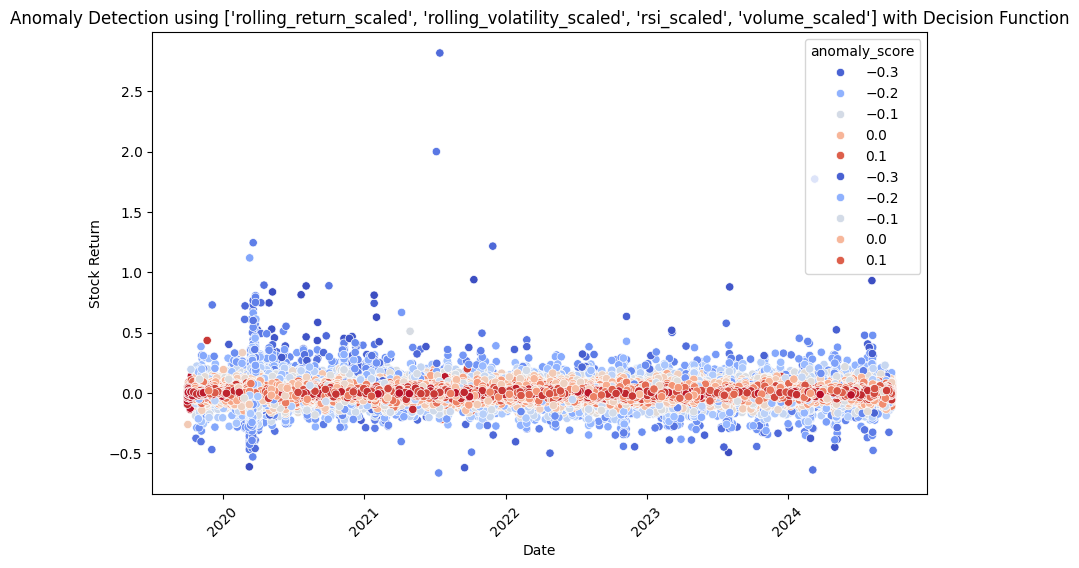

Train Anomaly Count: 
anomaly
 1    559210
-1     29429
Name: count, dtype: int64
Test Anomaly Count: 
anomaly
 1    139802
-1      7358
Name: count, dtype: int64
Evaluating combined features for performance with decision_function:
Evaluating model with features: ['rolling_return_scaled', 'rolling_volatility_scaled', 'rsi_scaled', 'volume_scaled']
Precision: 0.5126, Recall: 0.9513, F1 Score: 0.6662



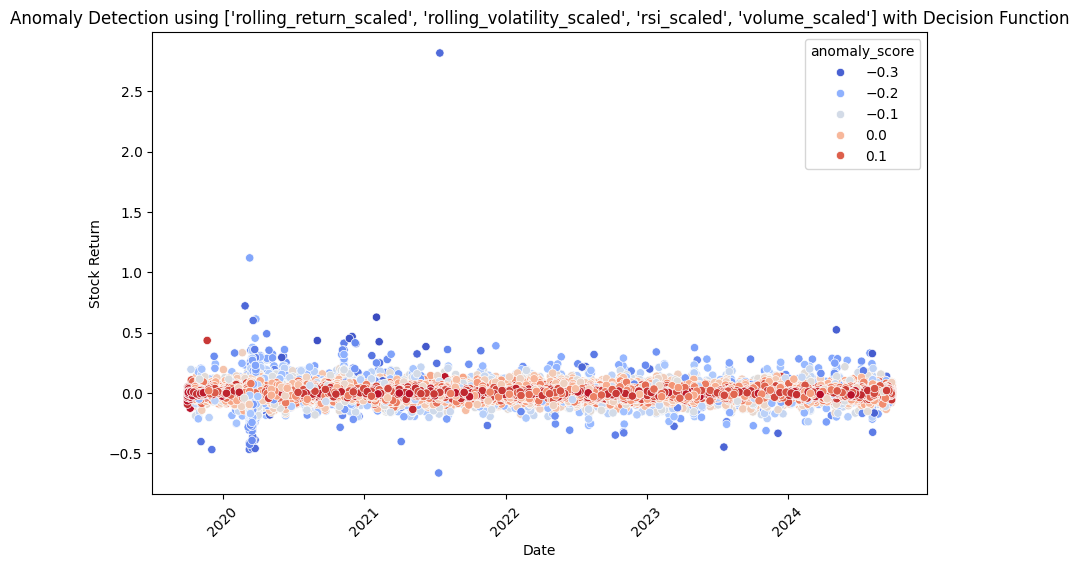

In [4]:
# Function to train Isolation Forest and compare results using decision_function
def train_and_evaluate_isolation_forest_with_scores(features, train_data, test_data):
    # Isolation Forest model
    iso_forest = IsolationForest(random_state=42)

    # Fit the model on the training set
    iso_forest.fit(train_data[features])

    # Get anomaly scores (decision_function)
    train_data['anomaly_score'] = iso_forest.decision_function(train_data[features])
    test_data['anomaly_score'] = iso_forest.decision_function(test_data[features])

    # Set threshold for anomalies (e.g., threshold = 0, lower scores indicate more anomalous)
    threshold = np.percentile(test_data['anomaly_score'], 5)  # e.g., using the 5th percentile as the threshold

    # Mark anomalies based on threshold
    train_data['anomaly'] = train_data['anomaly_score'].apply(lambda x: -1 if x < threshold else 1)
    test_data['anomaly'] = test_data['anomaly_score'].apply(lambda x: -1 if x < threshold else 1)

    # Count the anomalies
    train_anomaly_count = train_data['anomaly'].value_counts()
    test_anomaly_count = test_data['anomaly'].value_counts()

    # Plot the anomaly scores
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train_data, x='Date', y='Return', hue='anomaly_score', palette='coolwarm')
    sns.scatterplot(data=test_data, x='Date', y='Return', hue='anomaly_score', palette='coolwarm')
    plt.title(f'Anomaly Detection using {features} with Decision Function')
    plt.xlabel('Date')
    plt.ylabel('Stock Return')
    plt.xticks(rotation=45)
    plt.show()

    # Return train and test anomaly counts for comparison
    return train_anomaly_count, test_anomaly_count

# Example for combined features
print("Evaluating combined features with decision_function:")
for features in features_list:
    print(f"Evaluating model with features: {features}")
    train_anomaly_count, test_anomaly_count = train_and_evaluate_isolation_forest_with_scores(features, train_data, test_data)
    print(f"Train Anomaly Count: \n{train_anomaly_count}")
    print(f"Test Anomaly Count: \n{test_anomaly_count}")

# Function to train Isolation Forest and evaluate precision, recall, F1 score using decision_function
def evaluate_isolation_forest_performance_with_scores(features, train_data, test_data):
    # Isolation Forest model
    iso_forest = IsolationForest(random_state=42)
    
    # Fit the model on the training set
    iso_forest.fit(train_data[features])

    # Get anomaly scores (decision_function)
    test_data['anomaly_score'] = iso_forest.decision_function(test_data[features])

    # Set threshold for anomalies (e.g., threshold = 0)
    threshold = np.percentile(test_data['anomaly_score'], 5)
    test_data['anomaly'] = test_data['anomaly_score'].apply(lambda x: -1 if x < threshold else 1)

    # Assume negative returns are true anomalies (for evaluation purposes)
    true_anomalies = [-1 if x < 0 else 1 for x in test_data['Return']]

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_anomalies, test_data['anomaly'])
    recall = recall_score(true_anomalies, test_data['anomaly'])
    f1 = f1_score(true_anomalies, test_data['anomaly'])

    print(f"Evaluating model with features: {features}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

    # Plot the anomaly scores
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=test_data, x='Date', y='Return', hue='anomaly_score', palette='coolwarm')
    plt.title(f'Anomaly Detection using {features} with Decision Function')
    plt.xlabel('Date')
    plt.ylabel('Stock Return')
    plt.xticks(rotation=45)
    plt.show()

# Evaluate the combined features using decision_function
print("Evaluating combined features for performance with decision_function:")
for features in features_list:
    evaluate_isolation_forest_performance_with_scores(features, train_data, test_data)
